<h1><b>Documents Clustering Using Sequences Gathered From Word Of Graph<b></h1>

*Members*:<br>
K18-1044 Muhammad Arsalan Jamali<br>
K18-1074 Hussain Patan<br>
K18-0227 Hassan Ali

<h6>Lets install necessary Packages</h6>

In [69]:
!pip install contractions
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Importing Necessary Modules 

In [143]:
import os            #for OS related activities fetching directory, searching ,marking existence of directory
from string import punctuation  #importing build in punctuation's
from nltk.tokenize import word_tokenize  #importing build in tokenizer
import contractions  #for removing contractions for I'll -> I will
from nltk.stem import PorterStemmer  #importing porterstemmer algorithm 
import pickle  #for saving and loading linkage matrices
import numpy as np 
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [144]:
'''
  Initializing global variables in order to use them
  Afterwards
  '''
ps=PorterStemmer()
DATASET_DIR=os.path.join(os.getcwd(),'dataset/abcnews-date-text.csv')   #for dataset directory
DISK_READ=False #flag to check if index were fetched from disk for not

# Visualization and Cleaning Of Data

In [145]:
df=pd.read_csv(DATASET_DIR)
df.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103665 entries, 0 to 1103664
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   publish_date   1103665 non-null  int64 
 1   headline_text  1103665 non-null  object
dtypes: int64(1), object(1)
memory usage: 16.8+ MB


In [147]:
df.isna().sum() #Checks if there exist any null field

publish_date     0
headline_text    0
dtype: int64

In [148]:
print('Number of Rows:',len(df))

Number of Rows: 1103665


In [149]:
df[df['headline_text'].duplicated(keep=False)].sort_values('headline_text').head(8)

,publish_date,headline_text
57973,20031129,10 killed in pakistan bus crash
116304,20040920,10 killed in pakistan bus crash
912357,20141023,110 with barry nicholls
673104,20120217,110 with barry nicholls
676569,20120302,110 with barry nicholls
748865,20121214,110 with barry nicholls
827317,20131017,110 with barry nicholls episode 15
898182,20140820,110 with barry nicholls episode 15


As it appears that there are duplicated values hence we should eliminate them and should keep only one instance of each occurance

In [150]:
df=df.drop_duplicates('headline_text')

In [151]:
print('Number of Rows (After Removing Duplicates):',len(df))

Number of Rows (After Removing Duplicates): 1076225


# Creation of Word of Graph, Document Sequences

Below we create the Word of Graph Class which includes all the necessary functions for processing data and creating Graph of Word and Extracting Sequences in order to use it further in Bottom to Top Hierarchical Clustering 

In [152]:
class WordOfGraph:

  def __init__(self,df):
    global punctuation
    global DISK_READ
    punctuation+='“”’‘—'  #inorder to deal with punctuations of different unicode
    self.df=None
    self.word_of_graph=dict()
    self.sequences=dict()
    self.stop_word=["a", "is", "the", "of", "all", "and", "to", "can", "be", "as", "once"
                    , "for", "at", "am", "are", "has", "have", "had", "up", "his", "her", "in", "on", "no", "we", "do"]
    
    if os.path.exists((os.path.join(os.getcwd(),'WordOfGraph.json'))) and os.path.exists((os.path.join(os.getcwd(),'Sequences.json'))):
        DISK_READ=True
    
    if DISK_READ:
        with open('WordOfGraph.json','r') as json_file:
            self.word_of_graph=json.load(json_file)
        
        with open('Sequences.json','r') as json_file:
          self.sequences=json.load(json_file)
    else:
      self.df=df

  def pre_process(self,document):
    document=document.lower()  #lowers the text
    document=contractions.fix(document)  #remove contractions 
    document=document.translate(str.maketrans('','',punctuation))  #remove punctuations from text
    tokenize_word_list=word_tokenize(document) # make tokenizers 
    tokenize_word_list=[ word for word in tokenize_word_list if word not in self.stop_word ] #remove stop words
    tokenize_word_list=[ ps.stem(word) for word in tokenize_word_list ] #apply stemming 
    return tokenize_word_list
  
  def process_csv(self):
    doc_id=0
    for _,headline_txt in self.df.values:
      tokenize_list=self.pre_process(headline_txt)
      self.create_graph(tokenize_list,str(doc_id))
      doc_id+=1
    self.write_file()
  
  def create_graph(self,token_list,doc_id):
    if doc_id not in self.word_of_graph:
      self.word_of_graph[doc_id]=dict()
    if doc_id not in self.sequences:
      self.sequences[doc_id]=list()

    for index in range(0,len(token_list),2):
      tuple_to_add=None
      if index+2<len(token_list):
        tuple_to_add=tuple(token_list[index+1:index+3])
      else:
        if index!=len(token_list)-1:
          tuple_to_add=tuple(token_list[index+1:])

      word=token_list[index]
      if index!=len(token_list)-1:
        self.word_of_graph[doc_id][word]=tuple_to_add
        self.create_sequences(word,doc_id)
  
  def create_sequences(self,word,doc_id):    
    tuple_to_add=self.word_of_graph[doc_id][word]
    if len(tuple_to_add)<2:
      self.sequences[doc_id].append([word,tuple_to_add[0]])
    else:
      self.sequences[doc_id].append([word,tuple_to_add[0]])
      self.sequences[doc_id].append([word,tuple_to_add[1]])
  
  def write_file(self):
    wog_json=json.dumps(self.word_of_graph)  #writes both file in json format
    sequences_json=json.dumps(self.sequences)
    with open('WordOfGraph.json','w') as json_file:
        json_file.write(wog_json)
    with open('Sequences.json','w') as json_file:
        json_file.write(sequences_json)
  
  def display_graph(self,doc_id):
    doc_id=str(doc_id)
    WOG=nx.DiGraph()
    for node in self.word_of_graph[doc_id].keys():
        WOG.add_node(node,label=node)
    for X_edge,Y_edge in self.sequences[doc_id]:
        WOG.add_edge(X_edge,Y_edge)
    plt.figure(figsize=(15,8))
    plt.title("Document Number : "+str(doc_id),fontdict={'fontsize': 20, 'fontweight': 'bold'})
    nx.draw(WOG,pos=nx.nx_pydot.graphviz_layout(WOG),arrows=True, node_size=3500,node_color='green', linewidths=0.5, font_size=12, with_labels=True,font_color='white')
    plt.show()

  def create_similarity_matrix(self,size):
    sequences=self.sequences
    matrix=np.zeros((size,size),dtype=float)
    
    for i in range(0,size):
      d1=sequences[str(i)]
      if i%1000==0:
        print('Document Starting ({},{})'.format(i,i+1000))
      for j in range(0, size):
        if j==i:
          matrix[i][j]=1.0
        elif j<i:
          matrix[i][j]=matrix[j][i]
        else:
          intersection_count=0
          union_count=0
          d2=sequences[str(j)]
          for seq in d1:
            if seq in d2:
              intersection_count+=1

          union_count=len(d1)+len(d2)-intersection_count

          if union_count!=0:
            matrix[i][j]=intersection_count/union_count  

    return matrix



Loading or Creating the word of graph <br>
**=> Note this may take a while if the graph is being created kindly be patient enough and wait for approx 5 to 6 minutes**

In [153]:
graph=WordOfGraph(df)
if not DISK_READ:
  graph.process_csv()

Document Sequences and WOG must been created or loaded successfully and lets visualize it.

# Visualization of Word of Graph and Document Sequence

In [154]:
graph.sequences['1250']

[['council', 'offer'],
 ['council', 'land'],
 ['land', 'valuat'],
 ['land', 'rate'],
 ['rate', 'rise'],
 ['rate', 'assur']]

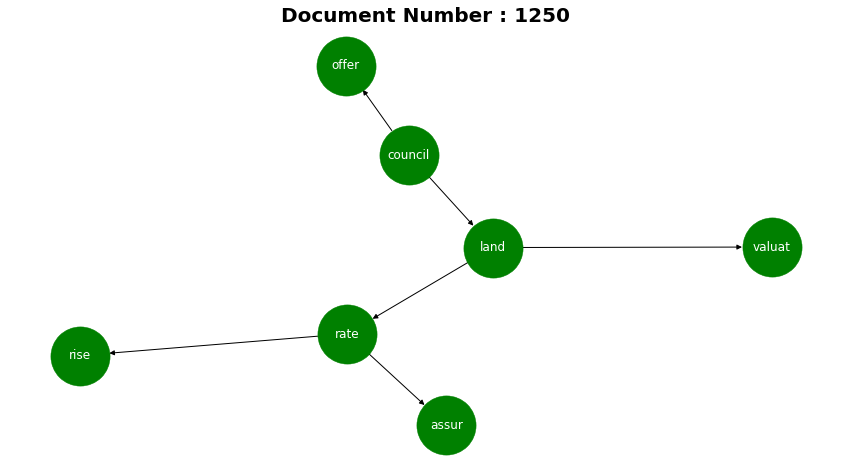

In [155]:
graph.display_graph(1250)

In [156]:
graph.sequences['250']

[['drought', 'take'], ['drought', 'toll'], ['toll', 'insect']]

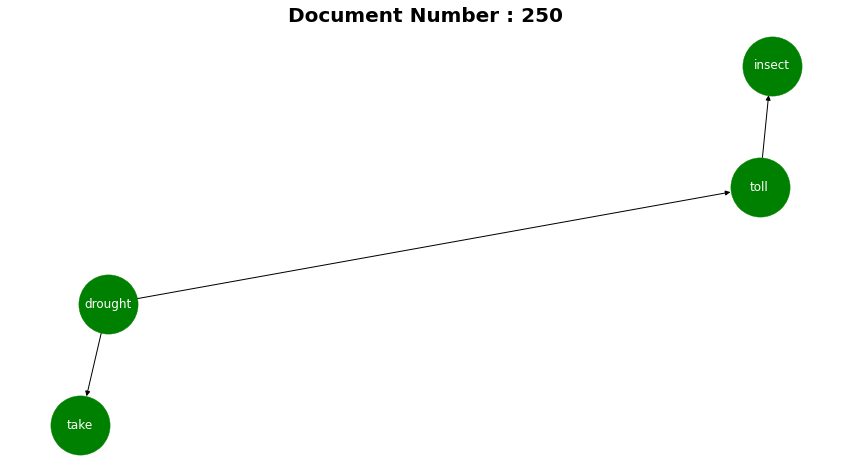

In [157]:
graph.display_graph(250)

# Initializing Similarity Matrix

In [158]:
Similarity_Matrix=None
if os.path.exists(os.path.join(os.getcwd(),'SimilarityMatrix.npy')):
  f=open('SimilarityMatrix.npy','rb')
  Similarity_Matrix=np.load(f)
  f.close()
else:
  Similarity_Matrix=graph.create_similarity_matrix(10000)
  with open('SimilarityMatrix.npy','wb') as f:
    np.save(f,Similarity_Matrix)

Similarity Matrix has been Created or Loaded Successfully

# Hierarchical Clustering Using Bottom-to-Top Approach

In [159]:
'''
  Importing necessary libraries for clustering and visualzing the clusters using dendrogram
'''
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score

Single_Method_Linkage=None
Complete_Method_Linkage=None
Average_Method_Linkage=None

**=> Single Method Clustering (Minimum Value Between Points)**

In [160]:
if os.path.exists(os.path.join(os.getcwd(),'single_method_linkage.p')):
  with open('single_method_linkage.p','rb') as f:
    Single_Method_Linkage=pickle.load(f)
else:
  Single_Method_Linkage=sch.linkage(Similarity_Matrix[0:5000][0:5000],method='single')
  with open('single_method_linkage.p', 'wb') as f:
    pickle.dump(Single_Method_Linkage,f,protocol=pickle.HIGHEST_PROTOCOL)    

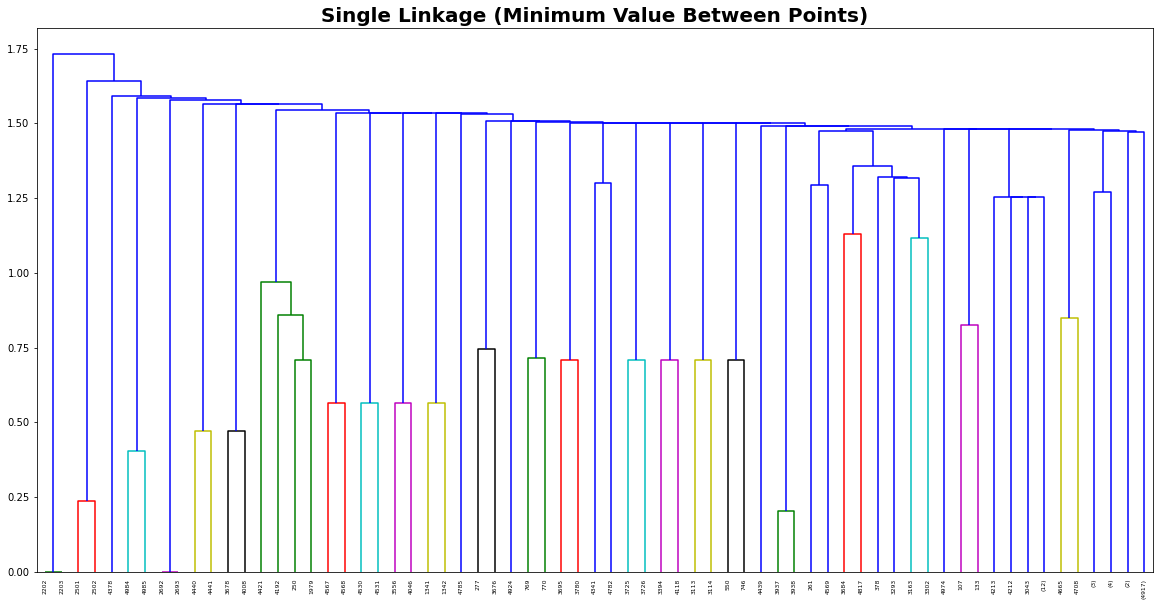

In [161]:
plt.figure(figsize=(20,10))
plt.title('Single Linkage (Minimum Value Between Points)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
dendrogram(Single_Method_Linkage,truncate_mode='level')
plt.show()

**=> Complete Method Clustering (Maximum Value Between Points)**

In [162]:
if os.path.exists(os.path.join(os.getcwd(),'complete_method_linkage.p')):
  with open('complete_method_linkage.p','rb') as f:
    Complete_Method_Linkage=pickle.load(f)
else:
  Complete_Method_Linkage=sch.linkage(Similarity_Matrix[0:5000][0:5000],method='complete')
  with open('complete_method_linkage.p', 'wb') as f:
    pickle.dump(Complete_Method_Linkage,f,protocol=pickle.HIGHEST_PROTOCOL)    

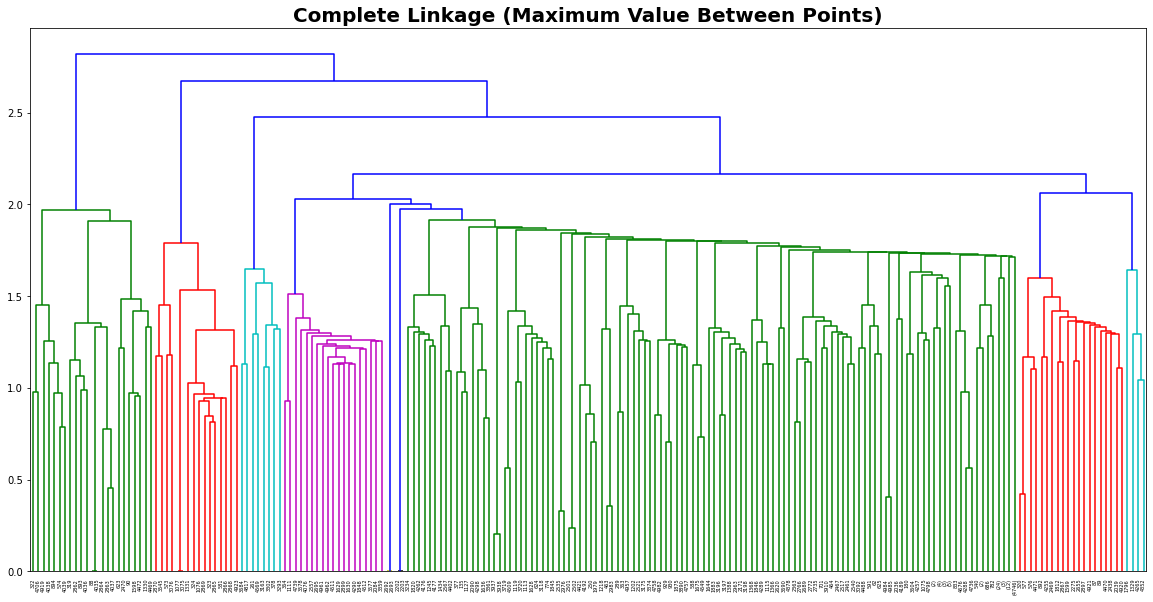

In [163]:
plt.figure(figsize=(20,10))
plt.title('Complete Linkage (Maximum Value Between Points)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
dendrogram(Complete_Method_Linkage ,truncate_mode='level')
plt.show()

**=> Average Method Clustering (Average Value Between Points)**

In [164]:
if os.path.exists(os.path.join(os.getcwd(),'average_method_linkage.p')):
  with open('average_method_linkage.p','rb') as f:
    Average_Method_Linkage=pickle.load(f)
else:
  Average_Method_Linkage=sch.linkage(Similarity_Matrix[0:5000][0:5000],method='average')
  with open('average_method_linkage.p', 'wb') as f:
    pickle.dump(Average_Method_Linkage,f,protocol=pickle.HIGHEST_PROTOCOL)    

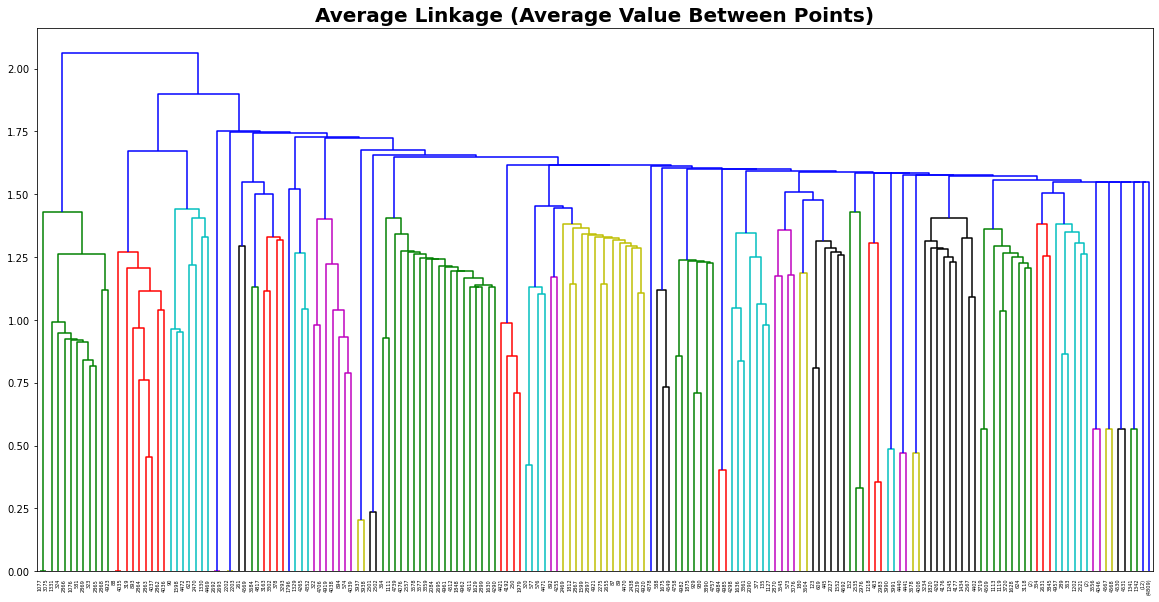

In [165]:
plt.figure(figsize=(20,10))
plt.title('Average Linkage (Average Value Between Points)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
dendrogram(Average_Method_Linkage,truncate_mode='level')
plt.show()

# Silhouette Score Testing

In [166]:
linkage_matrix=Similarity_Matrix[0:5000,0:5000]
np.fill_diagonal(linkage_matrix,0)
x_axis,y_axis=dict(),dict()

**=> Single Linkage Silhouette Score**

In [167]:
x_axis['single'],y_axis['single']=list(),list()
for cluster in range(3,400,40):
    nodes=sch.fcluster(Single_Method_Linkage,t=cluster,criterion='maxclust')
    silhouette_avg=silhouette_score(linkage_matrix,labels=nodes,metric='precomputed')
    print("The Average Silhouette Score is (t={}): {}".format(cluster,silhouette_avg))
    x_axis['single'].append(cluster)
    y_axis['single'].append(silhouette_avg)

The Average Silhouette Score is (t=3): -0.472
The Average Silhouette Score is (t=43): -0.4714
The Average Silhouette Score is (t=83): -0.4714
The Average Silhouette Score is (t=123): -0.4712
The Average Silhouette Score is (t=163): -0.4706
The Average Silhouette Score is (t=203): -0.4706
The Average Silhouette Score is (t=243): -0.47
The Average Silhouette Score is (t=283): -0.4698
The Average Silhouette Score is (t=323): -0.4698
The Average Silhouette Score is (t=363): -0.4696


**=> Complete Linkage Silhouette Score**

In [168]:
x_axis['complete'],y_axis['complete']=list(),list()
for cluster in range(3,400,40):
    nodes=sch.fcluster(Complete_Method_Linkage,t=cluster,criterion='maxclust')
    silhouette_avg=silhouette_score(linkage_matrix,labels=nodes,metric='precomputed')
    print("The Average Silhouette Score is (t={}): {}".format(cluster,silhouette_avg))
    x_axis['complete'].append(cluster)
    y_axis['complete'].append(silhouette_avg)

The Average Silhouette Score is (t=3): -0.4706070289847505
The Average Silhouette Score is (t=43): -0.4634
The Average Silhouette Score is (t=83): -0.4596
The Average Silhouette Score is (t=123): -0.4586
The Average Silhouette Score is (t=163): -0.4548
The Average Silhouette Score is (t=203): -0.4512
The Average Silhouette Score is (t=243): -0.4494
The Average Silhouette Score is (t=283): -0.449
The Average Silhouette Score is (t=323): -0.448
The Average Silhouette Score is (t=363): -0.4476


**=> Average Linkage Silhouette Score**

In [169]:
x_axis['average'],y_axis['average']=list(),list()
for cluster in range(3,400,40):
    nodes=sch.fcluster(Average_Method_Linkage,t=cluster,criterion='maxclust')
    silhouette_avg=silhouette_score(linkage_matrix,labels=nodes,metric='precomputed')
    print("The Average Silhouette Score is (t={}): {}".format(cluster,silhouette_avg))
    x_axis['average'].append(cluster)
    y_axis['average'].append(silhouette_avg)

The Average Silhouette Score is (t=3): -0.47100293420598865
The Average Silhouette Score is (t=43): -0.4656
The Average Silhouette Score is (t=83): -0.461
The Average Silhouette Score is (t=123): -0.4592
The Average Silhouette Score is (t=163): -0.457
The Average Silhouette Score is (t=203): -0.4564
The Average Silhouette Score is (t=243): -0.4554
The Average Silhouette Score is (t=283): -0.4544
The Average Silhouette Score is (t=323): -0.4544
The Average Silhouette Score is (t=363): -0.4544


# Visualizing Silhouette Score

Using Above tests<br>
**=> Single Linkage**

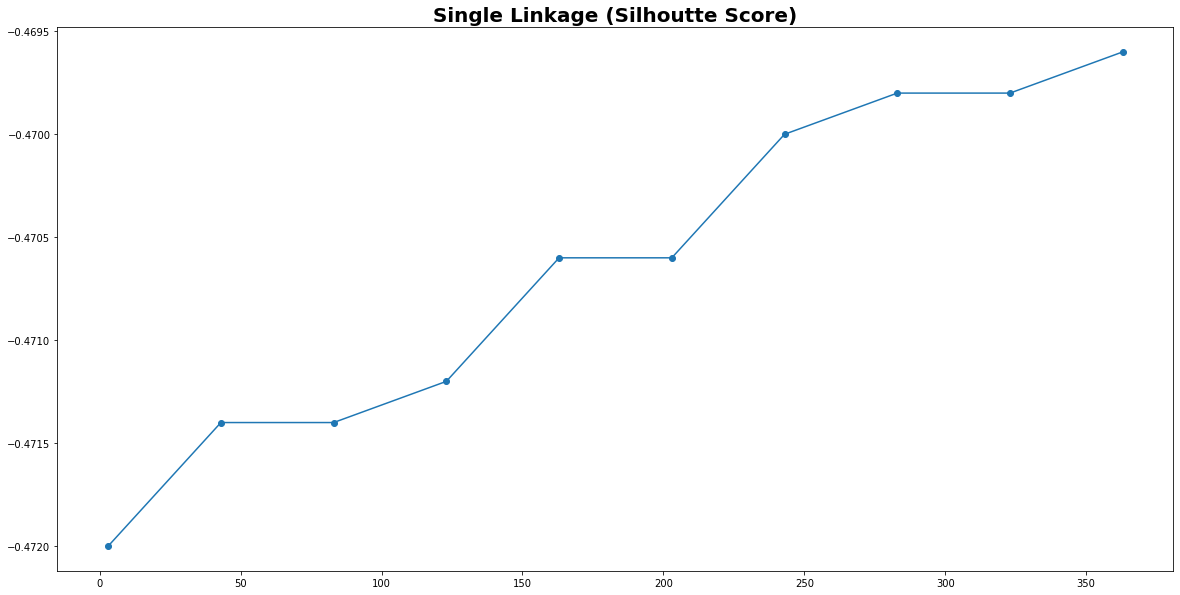

In [170]:
plt.figure(figsize=(20,10))
plt.title('Single Linkage (Silhoutte Score)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.scatter(x_axis['single'],y_axis['single'])
plt.plot(x_axis['single'],y_axis['single'])
plt.show()

**=> Average Linkage**

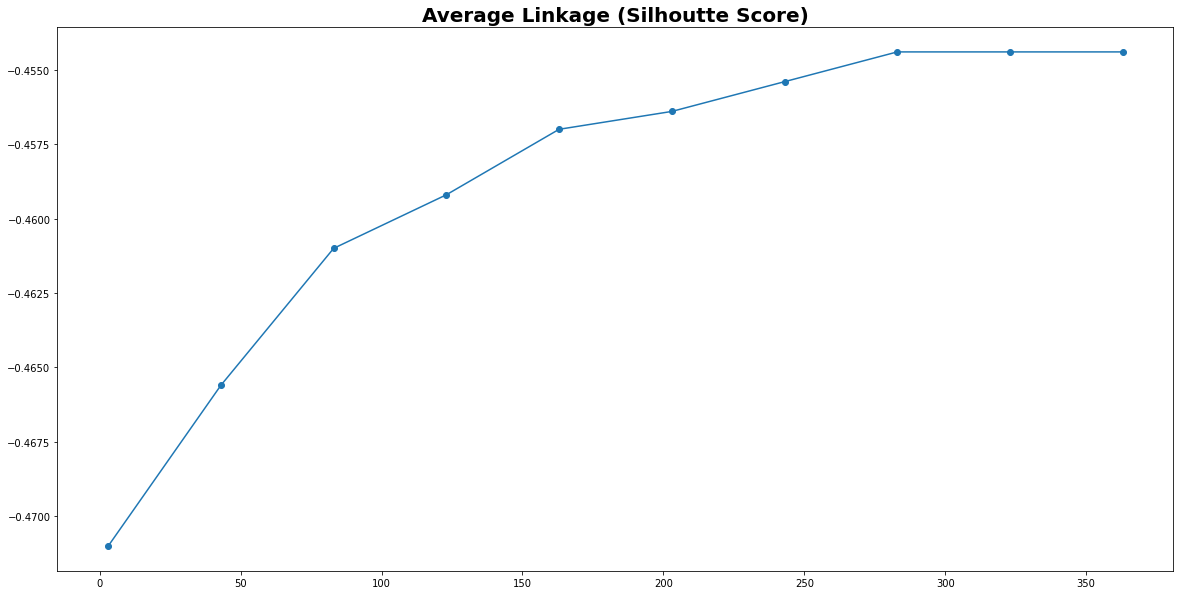

In [171]:
plt.figure(figsize=(20,10))
plt.title('Average Linkage (Silhoutte Score)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.scatter(x_axis['average'],y_axis['average'])
plt.plot(x_axis['average'],y_axis['average'])
plt.show()

**=> Complete Linkage**

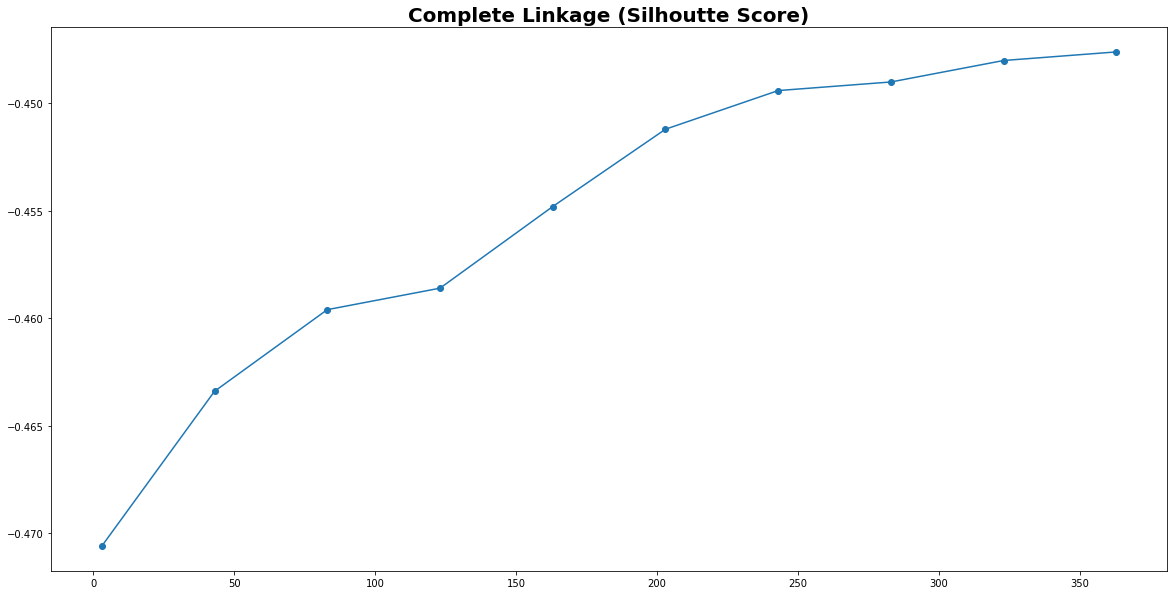

In [172]:
plt.figure(figsize=(20,10))
plt.title('Complete Linkage (Silhoutte Score)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.scatter(x_axis['complete'],y_axis['complete'])
plt.plot(x_axis['complete'],y_axis['complete'])
plt.show()